# <font  color = "#0093AF">Contact shift</font>

<a href="https://githubtocolab.com/alsinmr/SLEEPY_tutorial/blob/main/ColabNotebooks/Chapter5/Ch5_ContactShift.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>

The contact shift occurs due to an isotropic hyperfine coupling between an electron and a nucleus, where the electron relaxes quickly compared to the size of the coupling. The result is that the coupling is averaged away, and therefore only a single peak appeals. Due to the electron polarization, however, the apparent shift of the nucleus is altered, according to:

$$
\begin{equation}
\Delta_{CS}=\frac{A_{iso}}{2}*P_{e-}
\end{equation}
$$

where $A_{iso}$ is the size of the isotropic hyperfine coupling, and $P_{e-}$ is the electron polarization. Then, the size of the contact shift is dependent on temperature, since it depends on the electron polarization.

Correct calculation of the contact shift, and the more complex [pseudo-contact shift](../Chapter5/Ch5_PseudoContactShift.ipynb) requires correct thermalization of coherences, achieved in SLEEPY via Lindblad thermalization.$^1$

[1] C. Bengs, M. Levitt. [*J. Magn. Reson.*](https://doi.org/10.1016/j.jmr.2019.106645), **2020**, 310,106645.

## Setup

In [2]:
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt

## Build the spin-system

To observe the contact shift, we just need an electron-nuclear system with an isotropic hyperfine coupling (i.e. $A_{xx}=A_{yy}=A_{zz}$). We may use the above formula to predict the size of the contact shift.

In [3]:
ex=sl.ExpSys(v0H=850,Nucs=['13C','e-'],T_K=298)
Aiso=5000
ex.set_inter(Type='hyperfine',i0=0,i1=1,Axx=Aiso,Ayy=Aiso,Azz=Aiso)
print(f'We expect a contact shift of {Aiso/2*ex.Peq[1]:.2f} Hz')

We expect a contact shift of -112.55 Hz


## Define the Liouvillian, simulate without relaxation

We will run two simulations. In the first, there will be no relaxation present, just thermal polarization. In the latter, we'll add electron $T_1$ (and $T_2$, to keep physical behavior).

Note that to get the correct thermal polarization of the $S^\alpha I_x$ and $S^\beta I_x$, we have to start at thermal polarization and apply a $\pi$/2 pulse.

State-space reduction: 16->2


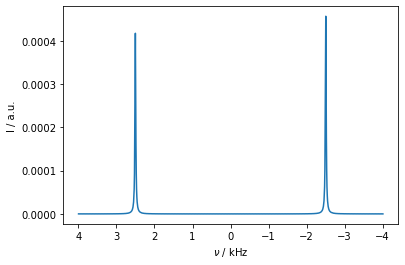

In [4]:
# No relaxation
L=ex.Liouvillian()     #Liouville object

# Define the sequence
Dt=1/4000/2 #Short enough time step for 8000 Hz spectral width
seq=L.Sequence(Dt=Dt)

# Create density matrix, prepare with pi/2 pulse
no_rlx=sl.Rho(rho0='Thermal',detect='13Cp')
Upi2=L.Udelta('13C',np.pi/2,np.pi/2)
Upi2*no_rlx

# Run and plot spectrum
no_rlx.DetProp(seq,n=512)
_=no_rlx.plot(axis='kHz',FT=True,apodize=True)

Indeed, we get two peaks for each state of the electron, but they have different amplitudes due to the electron polarization.

## Add relaxation

Here, we add fast $T_1$ and $T_2$ relaxation. We need the electrons to recover to their thermal equilibrium, so we use `L.add_relax(Type='recovery')` to thermalize the system. 

State-space reduction: 16->2


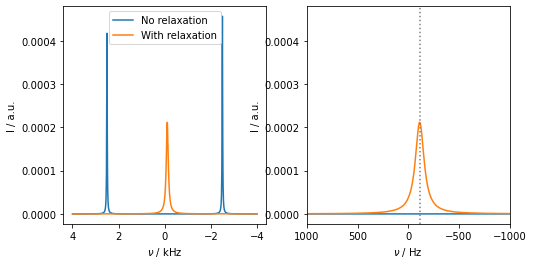

In [5]:
#Now add T1 relaxation
L.add_relax(Type='T1',i=1,T1=1e-6)
L.add_relax(Type='T2',i=1,T2=1e-9)
L.add_relax(Type='recovery')

# Define the sequence
Dt=1/8000 #Short enough time step for 8000 Hz spectral width
seq=L.Sequence(Dt=Dt)

# Create density matrix, prepare with pi/2 pulse
rlx=sl.Rho(rho0='Thermal',detect='13Cp')
Upi2=L.Udelta('13C',np.pi/2,np.pi/2)
Upi2*rlx

# Run
rlx.DetProp(seq,n=512)

# Plot
fig,ax=plt.subplots(1,2,figsize=[8,4])
no_rlx.plot(axis='kHz',FT=True,apodize=True,ax=ax[0])
rlx.plot(axis='kHz',FT=True,apodize=True,ax=ax[0])
ax[0].legend(('No relaxation','With relaxation'))
no_rlx.plot(axis='Hz',FT=True,apodize=True,ax=ax[1])
rlx.plot(axis='Hz',FT=True,apodize=True,ax=ax[1])
ax[1].set_xlim(1000,-1000)
ax[1].set_ylim(ax[1].get_ylim())
_=ax[1].plot(Aiso/2*ex.Peq[1]*np.ones(2),ax[1].get_ylim(),color='grey',linestyle=':')

Indeed, the resulting contact shift is exactly where expected (-112 Hz), as marked with the dashed line.

Without relaxation, we obtain two peaks at $\pm$2500 Hz, with the peak at -2500 Hz being slightly higher in amplitude, due to the higher electron polarization for that state. When electron $T_1$ relaxation is included, the two peaks get averaged together, weighted according to their amplitude, yielding the peak at -112 Hz. 

## Sweep the temperature
An interesting effect with the contact shift is its dependence on temperature. As we increase temperature, the peak gets smaller due to less polarization on the spin, and the contact shift is decreased, since the electron polarization is decreased.

State-space reduction: 16->2
State-space reduction: 16->2
State-space reduction: 16->2
State-space reduction: 16->2
State-space reduction: 16->2
State-space reduction: 16->2
State-space reduction: 16->2
State-space reduction: 16->2


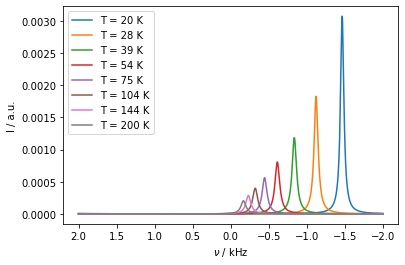

In [6]:
rho=sl.Rho(rho0='Thermal',detect='13Cp')
Dt=1/4000 #Short enough time step for 4000 Hz spectral width
seq=L.Sequence(Dt=Dt)

ax=plt.figure().add_subplot(111)
T=np.logspace(np.log10(20),np.log10(200),8)
for T_K in T:
    ex.T_K=T_K
    
    rho.clear()
    Upi2*rho
    rho.DetProp(seq,n=4096)
    
    rho.plot(FT=True,apodize=True,ax=ax,axis='kHz')
ax.figure.set_size_inches([6,4])
_=ax.legend([f'T = {T_K:.0f} K' for T_K in T])

Note that the contact shift has the same dependence on magnetic field as a normal chemical shift: the hyperfine coupling remains fixed with field, but the electron polarization grows linearly with field (in the high-temperature approximation)

State-space reduction: 16->2
State-space reduction: 16->2
State-space reduction: 16->2
State-space reduction: 16->2
State-space reduction: 16->2
State-space reduction: 16->2


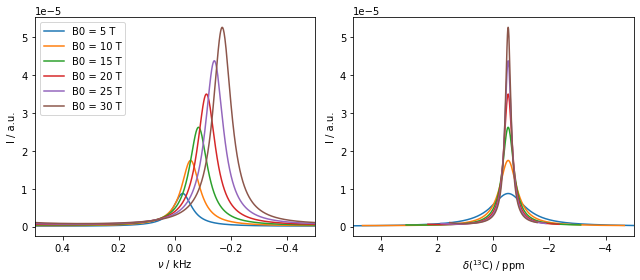

In [7]:
ex.T_K=200
rho=sl.Rho(rho0='Thermal',detect='13Cp')
Dt=1/1000 #Short enough time step for 4000 Hz spectral width

fig,ax=plt.subplots(1,2)
fig.set_size_inches([9,4])

B00=np.linspace(5,30,6)
for B0 in B00:
    ex=sl.ExpSys(B0=B0,Nucs=['13C','e-'],T_K=298)
    ex.set_inter(Type='hyperfine',i0=0,i1=1,Axx=Aiso,Ayy=Aiso,Azz=Aiso)
    L=ex.Liouvillian()
    L.add_relax(Type='T1',i=1,T1=1e-6)
    L.add_relax(Type='T2',i=1,T2=1e-9)
    L.add_relax(Type='recovery')
    seq=L.Sequence(Dt=Dt)
    Upi2=L.Udelta('13C',phi=np.pi/2,phase=np.pi/2)
    
    rho.clear()
    Upi2*rho
    rho.DetProp(seq,n=4096)
    
    rho.plot(FT=True,apodize=True,ax=ax[0],axis='kHz')
    rho.plot(FT=True,apodize=True,ax=ax[1],axis='ppm')

ax[0].legend([f'B0 = {B0:.0f} T' for B0 in B00])
ax[0].set_xlim([0.5,-0.5])
ax[1].set_xlim([5,-5])
fig.tight_layout()

If the temperature approaches 0 K, then the electron is no longer in the high-temperature approximation, and therefore the contact shift is no longer linear with the field, as demonstrated below.

State-space reduction: 16->2
State-space reduction: 16->2
State-space reduction: 16->2
State-space reduction: 16->2
State-space reduction: 16->2
State-space reduction: 16->2


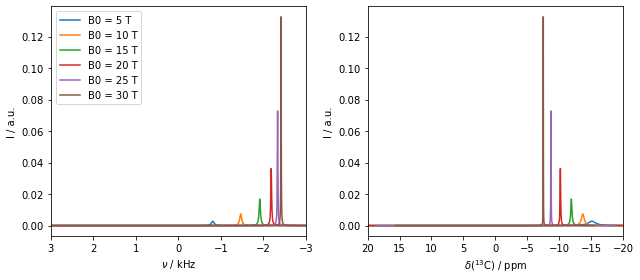

In [9]:
rho=sl.Rho(rho0='Thermal',detect='13Cp')
Dt=1/5000/2 #Short enough time step for 4000 Hz spectral width


fig,ax=plt.subplots(1,2)
fig.set_size_inches([9,4])

B00=np.linspace(5,30,6)
for B0 in B00:
    ex=sl.ExpSys(B0=B0,Nucs=['13C','e-'],T_K=10)
    ex.set_inter(Type='hyperfine',i0=0,i1=1,Axx=Aiso,Ayy=Aiso,Azz=Aiso)
    L=ex.Liouvillian()
    L.add_relax(Type='T1',i=1,T1=1e-6)
    L.add_relax(Type='T2',i=1,T2=1e-9)
    L.add_relax(Type='recovery')
    seq=L.Sequence(Dt=Dt)
    Upi2=L.Udelta('13C',phi=np.pi/2,phase=np.pi/2)
    
    rho.clear()
    Upi2*rho
    rho.DetProp(seq,n=4096)
    rho.plot(FT=True,apodize=True,ax=ax[0],axis='kHz')
    rho.plot(FT=True,apodize=True,ax=ax[1],axis='ppm')
    
ax[0].legend([f'B0 = {B0:.0f} T' for B0 in B00])
ax[0].set_xlim([3,-3])
ax[1].set_xlim([20,-20])
fig.tight_layout()

The contact shift only occurs where an isotropic hyperfine coupling is present, so no through-space contact shift occurs. On the other hand, the dipolar-modulated pseudocontact shift, discussed in the next [section](Ch5_PseudoContactShift.ipynb), can induce a similar effect.